# SM2 — Visual Storytelling: Let the Data Speak

A single notebook of visuals that **speak louder than words**, using the public SM2 dataset.
We focus on **summer behavior** (2024 & 2025), highlighting **heat build-up** and **differences across sections and spaces**.

Guidelines used:
- Timestamps converted to **Europe/Prague**.
- **Matplotlib only**, one figure per plot, no explicit colors.
- Export all figures into `outputs/`.


In [2]:
try:
    import pandas as pd
    import matplotlib
except Exception:
    %pip install -q pandas pyarrow matplotlib gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os, re

plt.rcParams['figure.figsize'] = (12, 6)
OUT_DIR = Path('outputs'); OUT_DIR.mkdir(exist_ok=True)


## Load dataset (Parquet preferred)

In [3]:
PARQUET_ID = "1gLPWgUGtRb371Gpv5O8t5j95lthNjELg"  # sm2_public_dataset.parquet
CSVGZ_ID  = "1eLOAOZ13--EKE63GZhmerjmY9zkeJcyd"  # sm2_public_dataset.csv.gz
USE_PARQUET = True

parquet_path = Path('sm2_public_dataset.parquet')
csvgz_path   = Path('sm2_public_dataset.csv.gz')

def gdown_download(file_id: str, out_path: Path):
    import subprocess, sys
    try:
        import gdown  # type: ignore
    except Exception:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'gdown'])
        import gdown  # type: ignore
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, str(out_path), quiet=False)

if USE_PARQUET:
    if not parquet_path.exists():
        print('Downloading Parquet…')
        gdown_download(PARQUET_ID, parquet_path)
else:
    if not csvgz_path.exists():
        print('Downloading CSV.GZ…')
        gdown_download(CSVGZ_ID, csvgz_path)

if USE_PARQUET and parquet_path.exists():
    df = pd.read_parquet(parquet_path)
elif csvgz_path.exists():
    df = pd.read_csv(csvgz_path, compression='gzip')
else:
    raise FileNotFoundError('Dataset not found. Check IDs or internet access.')

df['time'] = pd.to_datetime(df['time'], utc=True, errors='coerce')
df['data_value'] = pd.to_numeric(df['data_value'], errors='coerce')
df['local_time'] = df['time'].dt.tz_convert('Europe/Prague')
df['local_day'] = df['local_time'].dt.floor('D')
df['year'] = df['local_time'].dt.year
print('Shape:', df.shape)
df.head(3)


Downloading...
From: https://drive.google.com/uc?id=1gLPWgUGtRb371Gpv5O8t5j95lthNjELg
To: /content/sm2_public_dataset.parquet
100%|██████████| 1.29M/1.29M [00:00<00:00, 33.6MB/s]


Shape: (651332, 9)


,time,location,source,measurement,data_key,data_value,local_time,local_day,year
0,2023-11-30 13:00:00+00:00,sm2_01,Atrea,nonadditive,temp_ambient,4.0,2023-11-30 14:00:00+01:00,2023-11-30 00:00:00+01:00,2023
1,2023-11-30 13:00:00+00:00,sm2_01,Atrea,nonadditive,temp_fresh,20.3,2023-11-30 14:00:00+01:00,2023-11-30 00:00:00+01:00,2023
2,2023-11-30 13:00:00+00:00,sm2_01,Atrea,nonadditive,temp_indoor,21.4,2023-11-30 14:00:00+01:00,2023-11-30 00:00:00+01:00,2023


## Helper filters & constants

In [4]:
SUMMER_START = {
    2024: pd.Timestamp('2024-06-01', tz='Europe/Prague'),
    2025: pd.Timestamp('2025-06-01', tz='Europe/Prague')
}
SUMMER_END = {
    2024: pd.Timestamp('2024-08-31', tz='Europe/Prague'),
    2025: pd.Timestamp('2025-08-31', tz='Europe/Prague')
}

def summer_rows(frame: pd.DataFrame) -> pd.DataFrame:
    return frame[(
        ((frame['year']==2024) & (frame['local_day']>=SUMMER_START[2024]) & (frame['local_day']<=SUMMER_END[2024])) |
        ((frame['year']==2025) & (frame['local_day']>=SUMMER_START[2025]) & (frame['local_day']<=SUMMER_END[2025]))
    )].copy()

atrea = df[df['source']=='Atrea'].copy()
thermo = df[(df['source']=='ThermoPro') & (df['data_key']=='temp_indoor')].copy()

summer_atrea = summer_rows(atrea)
summer_thermo = summer_rows(thermo)
summer_atrea['hod'] = summer_atrea['local_time'].dt.hour
summer_thermo['hod'] = summer_thermo['local_time'].dt.hour
print('Atrea summer rows:', len(summer_atrea), 'ThermoPro summer rows:', len(summer_thermo))


Atrea summer rows: 172842 ThermoPro summer rows: 9776


## 1) "Summer Fingerprint" — Hour×Day Heatmaps

**Why it speaks**: A heatmap of **hour-of-day vs day** shows daily rhythm and heat retention at night.

- We build a **fingerprint** for `Atrea temp_indoor` per section.
- We show it for the **top 6 sections** with the largest number of summer rows.

Top 6 sections: ['sm2_01', 'sm2_02', 'sm2_03', 'sm2_04', 'sm2_05', 'sm2_06']


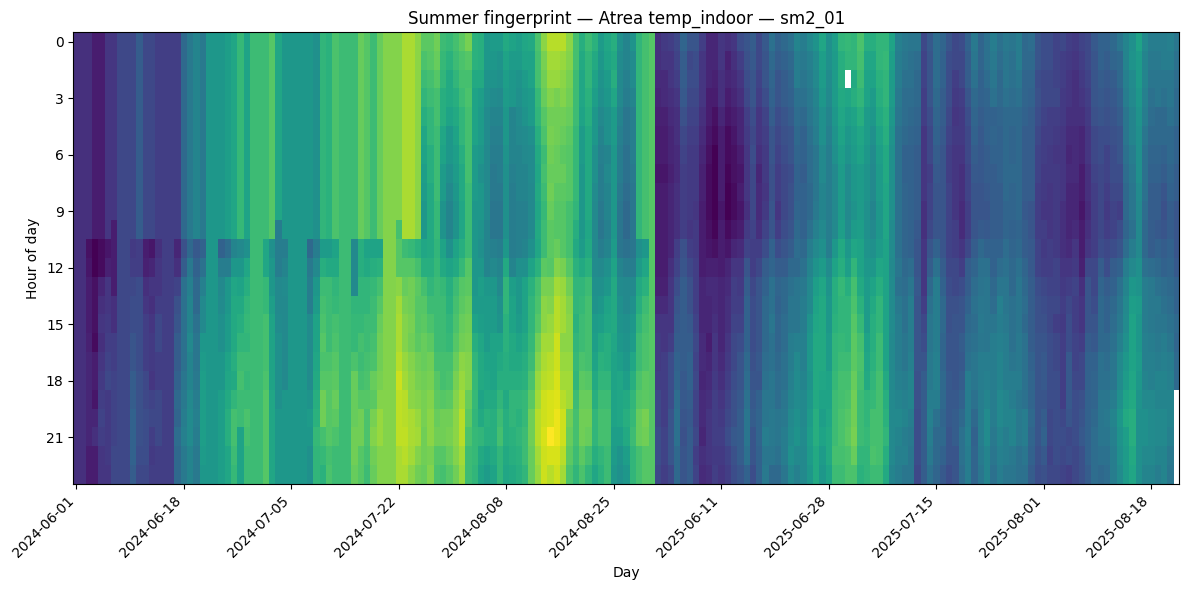

Saved: outputs/fingerprint_atrea_sm2_01.png


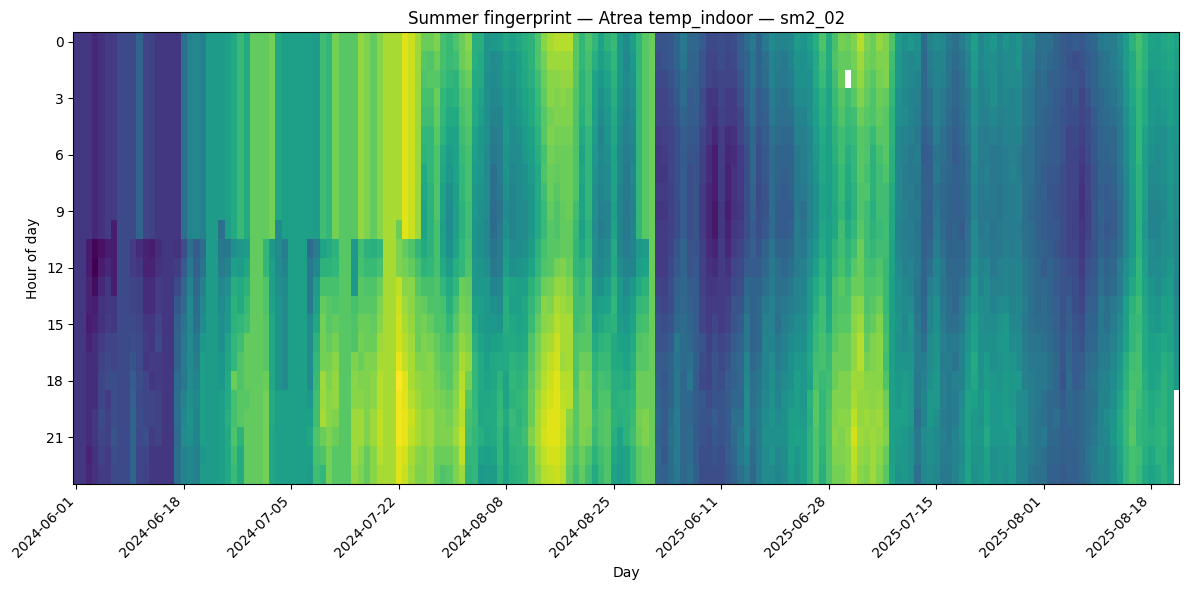

Saved: outputs/fingerprint_atrea_sm2_02.png


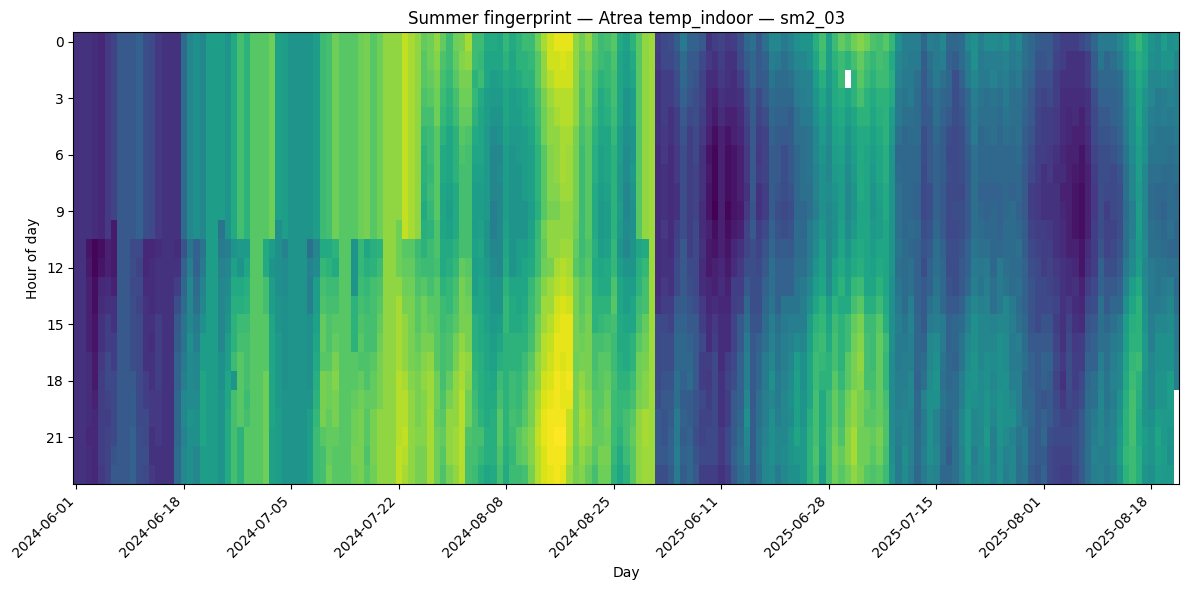

Saved: outputs/fingerprint_atrea_sm2_03.png


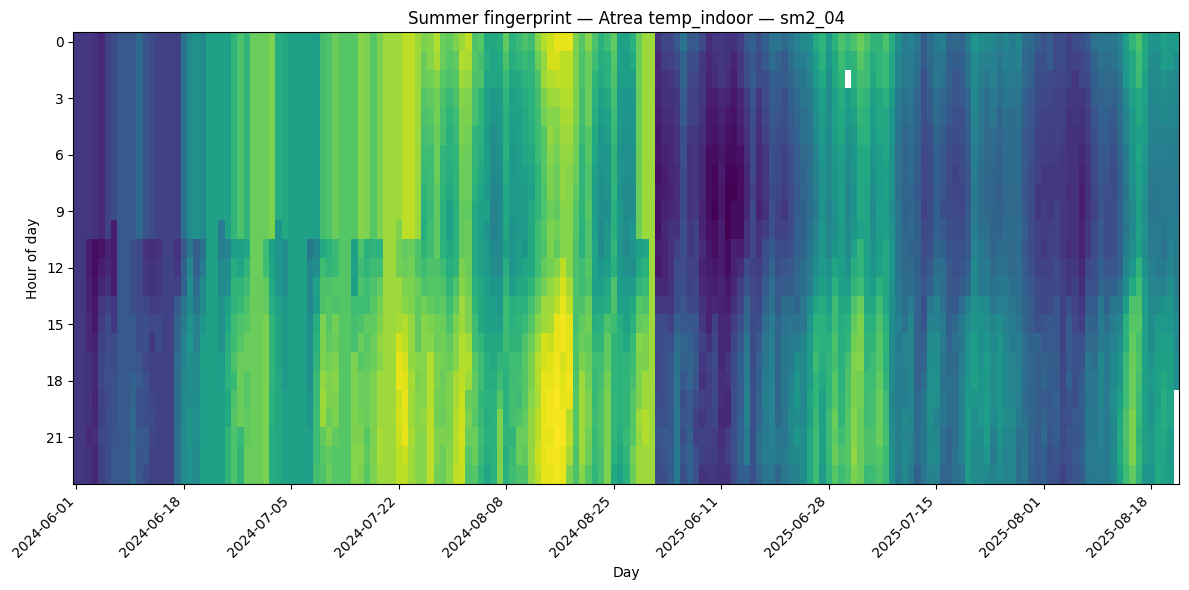

Saved: outputs/fingerprint_atrea_sm2_04.png


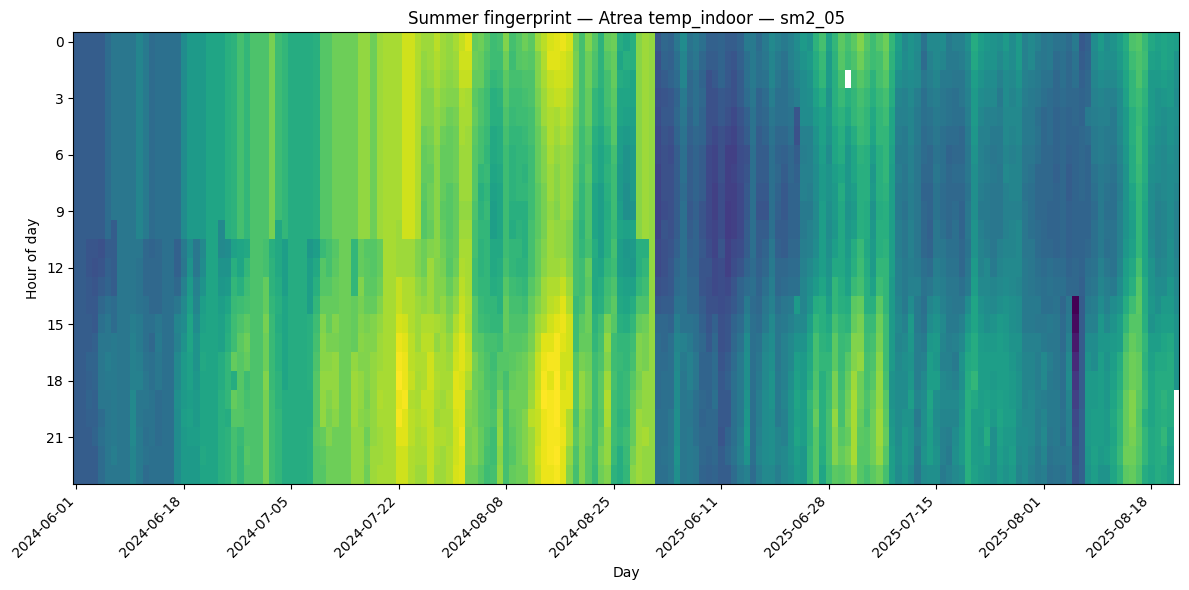

Saved: outputs/fingerprint_atrea_sm2_05.png


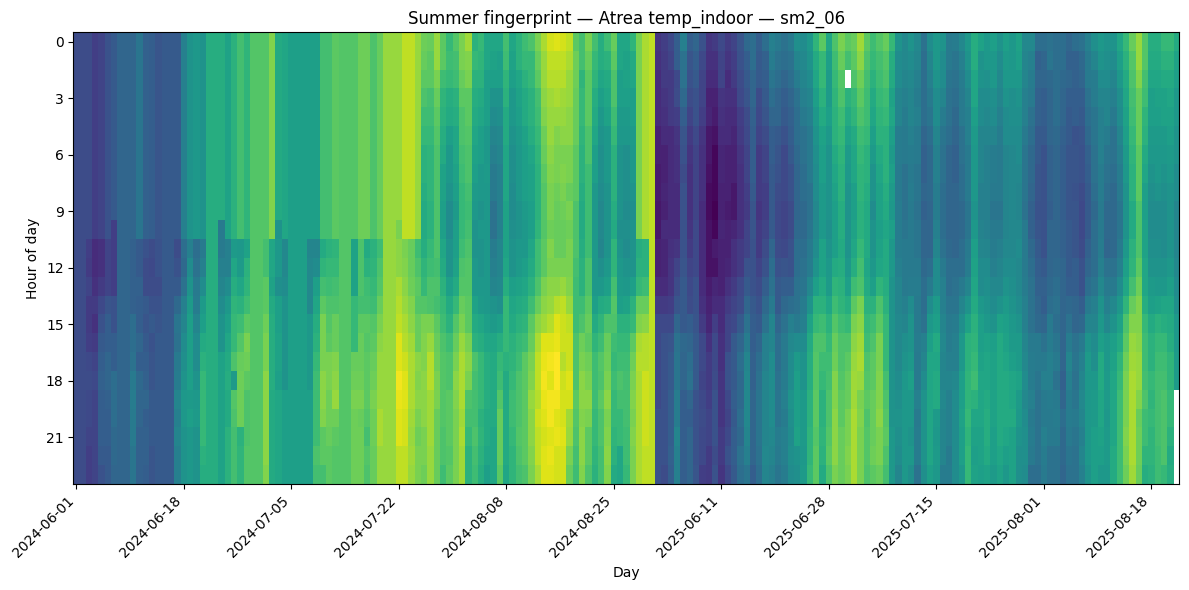

Saved: outputs/fingerprint_atrea_sm2_06.png


In [5]:
atr_in = summer_atrea[summer_atrea['data_key']=='temp_indoor'].copy()
sec_order = atr_in['location'].value_counts().head(6).index.tolist()
print('Top 6 sections:', sec_order)

for loc in sec_order:
    sub = atr_in[atr_in['location']==loc].copy()
    sub['day'] = sub['local_day']
    pivot = sub.pivot_table(index='hod', columns='day', values='data_value', aggfunc='mean')
    fig = plt.figure(); ax = plt.gca()
    im = ax.imshow(pivot.values, aspect='auto', interpolation='nearest')
    ax.set_title(f'Summer fingerprint — Atrea temp_indoor — {loc}')
    ax.set_yticks(range(0, 24, 3)); ax.set_yticklabels(list(range(0, 24, 3)))
    xticks = range(0, len(pivot.columns), max(1, len(pivot.columns)//10))
    ax.set_xticks(xticks)
    ax.set_xticklabels([str(d.date()) for i, d in enumerate(pivot.columns) if i in xticks], rotation=45, ha='right')
    ax.set_xlabel('Day'); ax.set_ylabel('Hour of day')
    plt.tight_layout();
    fname = OUT_DIR / f'fingerprint_atrea_{loc}.png'
    plt.savefig(fname, dpi=150); plt.show(); print('Saved:', fname)


## 2) "Cumulative Heat Burden" — Degree-hour curves

**Why it speaks**: Shows **how fast sections accumulate heat** above a comfort baseline.

- Compute hourly **excess over 26 °C** and plot **cumulative sum** over summer per section.
- We plot **all Atrea sections** in one figure to show separation.

/tmp/ipython-input-2488106225.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ex['hour_bin'] = ex['local_time'].dt.floor('H')


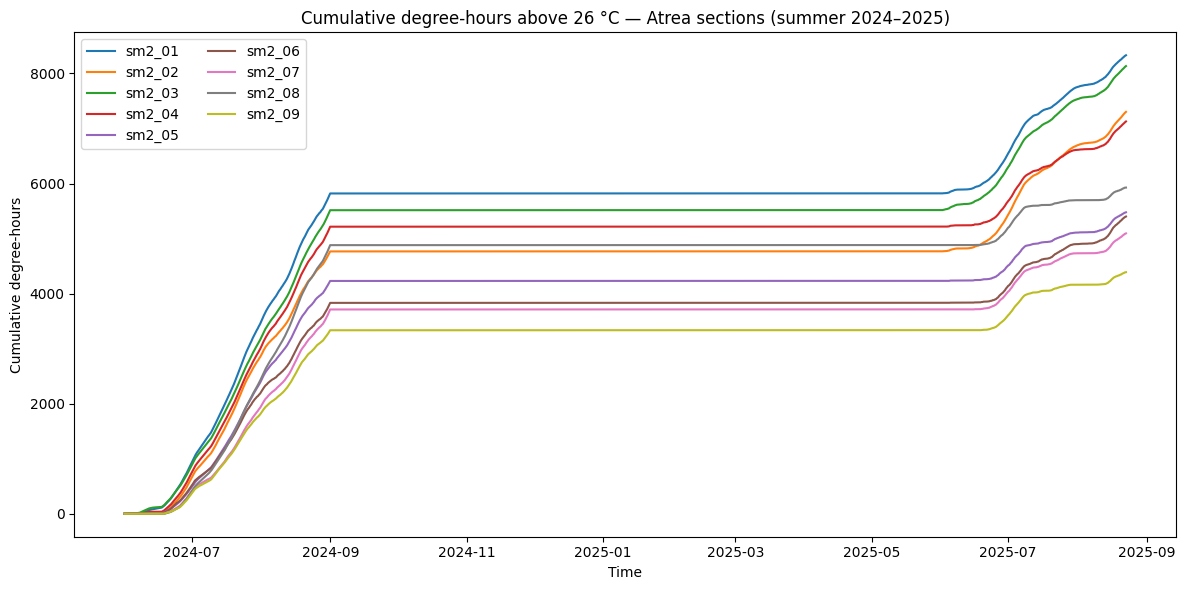

Saved: outputs/cumulative_deg_hours_by_section.png


In [6]:
ex = atr_in.copy()
ex['hour_bin'] = ex['local_time'].dt.floor('H')
hourly = ex.groupby(['location','hour_bin'])['data_value'].mean().reset_index()
hourly['excess26'] = (hourly['data_value'] - 26.0).clip(lower=0)
hourly = hourly.sort_values('hour_bin')

fig = plt.figure(); ax = plt.gca()
for loc, sub in hourly.groupby('location'):
    s = sub.set_index('hour_bin')['excess26'].cumsum()
    ax.plot(s.index, s.values, label=loc)
ax.set_title('Cumulative degree-hours above 26 °C — Atrea sections (summer 2024–2025)')
ax.set_xlabel('Time'); ax.set_ylabel('Cumulative degree-hours')
ax.legend(ncol=2)
plt.tight_layout(); plt.savefig(OUT_DIR / 'cumulative_deg_hours_by_section.png', dpi=150); plt.show()
print('Saved:', OUT_DIR / 'cumulative_deg_hours_by_section.png')


## 3) "Rank Race" — Daily rank of sections by daily max

**Why it speaks**: A **bump-like** chart reveals **rank dynamics** and persistent laggards/leaders.

- Compute **daily max** `temp_indoor` per section, then convert to **rank** (1=hotter).

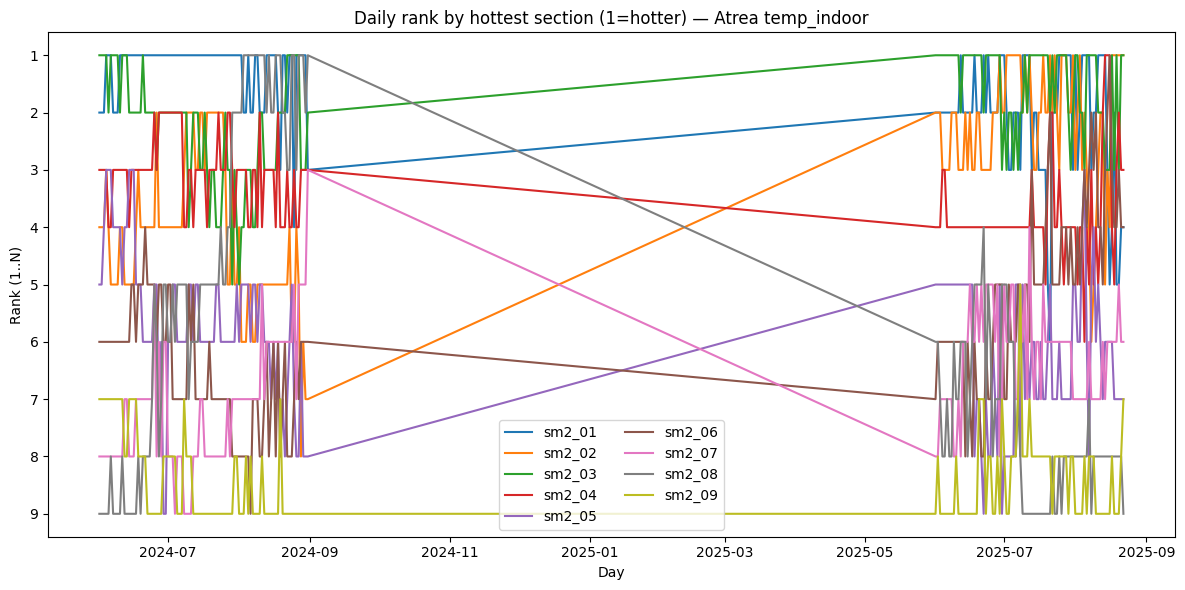

Saved: outputs/rank_race_daily_max.png


In [7]:
dmax = (atr_in.groupby(['location','local_day'])['data_value']
               .max()
               .reset_index(name='daily_max'))
def rank_per_day(df):
    df = df.copy()
    df['rank'] = df.groupby('local_day')['daily_max'].rank(method='min', ascending=False)
    return df
r = rank_per_day(dmax)
fig = plt.figure(); ax = plt.gca()
for loc, sub in r.groupby('location'):
    sub = sub.sort_values('local_day')
    ax.plot(sub['local_day'], sub['rank'], label=loc)
ax.set_title('Daily rank by hottest section (1=hotter) — Atrea temp_indoor')
ax.set_xlabel('Day'); ax.set_ylabel('Rank (1..N)')
ax.invert_yaxis()
ax.legend(ncol=2)
plt.tight_layout(); plt.savefig(OUT_DIR / 'rank_race_daily_max.png', dpi=150); plt.show()
print('Saved:', OUT_DIR / 'rank_race_daily_max.png')


## 4) "Night Gap" — Indoor vs Ambient at night (heat retention)

**Why it speaks**: A persistent **night-time gap** vs outdoors shows **accumulated heat**.

- Compute **mean night (00–05)** temperature for `temp_indoor` and `temp_ambient` per day (averaged across sections).
- Plot both series across the summer.

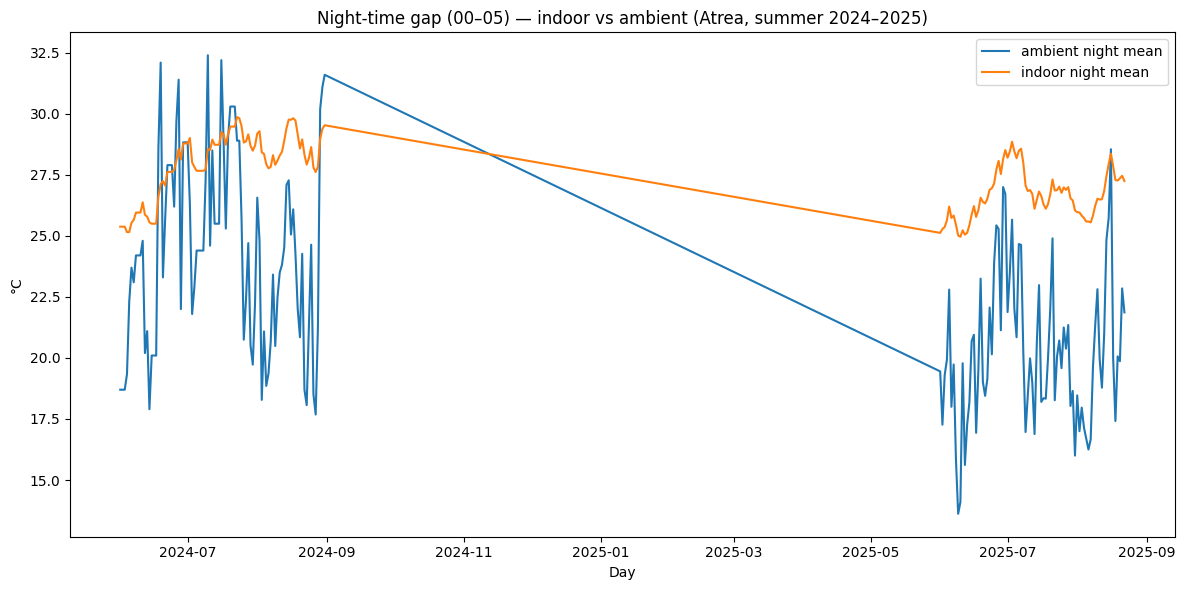

Saved: outputs/night_gap_indoor_vs_ambient.png


In [8]:
amb = summer_atrea[summer_atrea['data_key']=='temp_ambient'].copy()
ind = summer_atrea[summer_atrea['data_key']=='temp_indoor'].copy()
amb['hour'] = amb['local_time'].dt.hour
ind['hour'] = ind['local_time'].dt.hour
amb_night = amb[amb['hour'].between(0,5)]
ind_night = ind[ind['hour'].between(0,5)]
d_amb = amb_night.groupby('local_day')['data_value'].mean().reset_index(name='ambient_night')
d_ind = ind_night.groupby('local_day')['data_value'].mean().reset_index(name='indoor_night')
m = pd.merge(d_amb, d_ind, on='local_day', how='outer').sort_values('local_day')
fig = plt.figure(); ax = plt.gca()
ax.plot(m['local_day'], m['ambient_night'], label='ambient night mean')
ax.plot(m['local_day'], m['indoor_night'], label='indoor night mean')
ax.set_title('Night-time gap (00–05) — indoor vs ambient (Atrea, summer 2024–2025)')
ax.set_xlabel('Day'); ax.set_ylabel('°C')
ax.legend()
plt.tight_layout(); plt.savefig(OUT_DIR / 'night_gap_indoor_vs_ambient.png', dpi=150); plt.show()
print('Saved:', OUT_DIR / 'night_gap_indoor_vs_ambient.png')


## 5) "Lag Scatter" — How much does indoor cool after an outdoor cool-down?

**Why it speaks**: Quantifies **thermal inertia** — indoor temps drop less and slower.

- Compute daily mean `temp_ambient` and `temp_indoor` (Atrea, averaged across sections).
- Scatter **Δ ambient (day t → t+1)** vs **Δ indoor (t → t+1)**; slope < 1 indicates inertia.

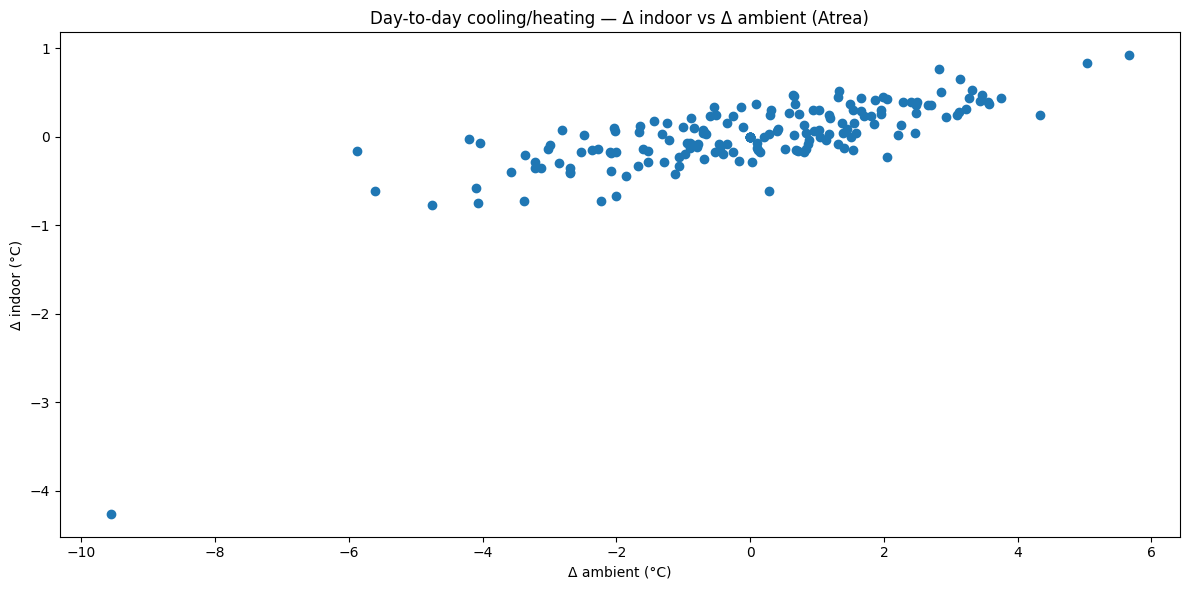

Saved: outputs/lag_scatter_ambient_vs_indoor_deltas.png


In [9]:
amb_d = summer_atrea[summer_atrea['data_key']=='temp_ambient'].groupby('local_day')['data_value'].mean().reset_index(name='amb')
ind_d = summer_atrea[summer_atrea['data_key']=='temp_indoor'].groupby('local_day')['data_value'].mean().reset_index(name='ind')
mm = pd.merge(amb_d, ind_d, on='local_day', how='inner').sort_values('local_day')
mm['d_amb'] = mm['amb'].diff()
mm['d_ind'] = mm['ind'].diff()
fig = plt.figure(); ax = plt.gca()
ax.scatter(mm['d_amb'], mm['d_ind'])
ax.set_title('Day-to-day cooling/heating — Δ indoor vs Δ ambient (Atrea)')
ax.set_xlabel('Δ ambient (°C)'); ax.set_ylabel('Δ indoor (°C)')
plt.tight_layout(); plt.savefig(OUT_DIR / 'lag_scatter_ambient_vs_indoor_deltas.png', dpi=150); plt.show()
print('Saved:', OUT_DIR / 'lag_scatter_ambient_vs_indoor_deltas.png')


## 6) "Corridor Signature" — 5NP corridors vs ambient

**Why it speaks**: Shows whether corridors act as **heat stores** or **vent paths**.

- Compute hour-of-day mean **Δ = corridor temp − ambient** for all **5NP** locations; plot all in one figure.
- If lines sit **above zero**, corridors stay warmer than outdoors → potential heat reservoir.

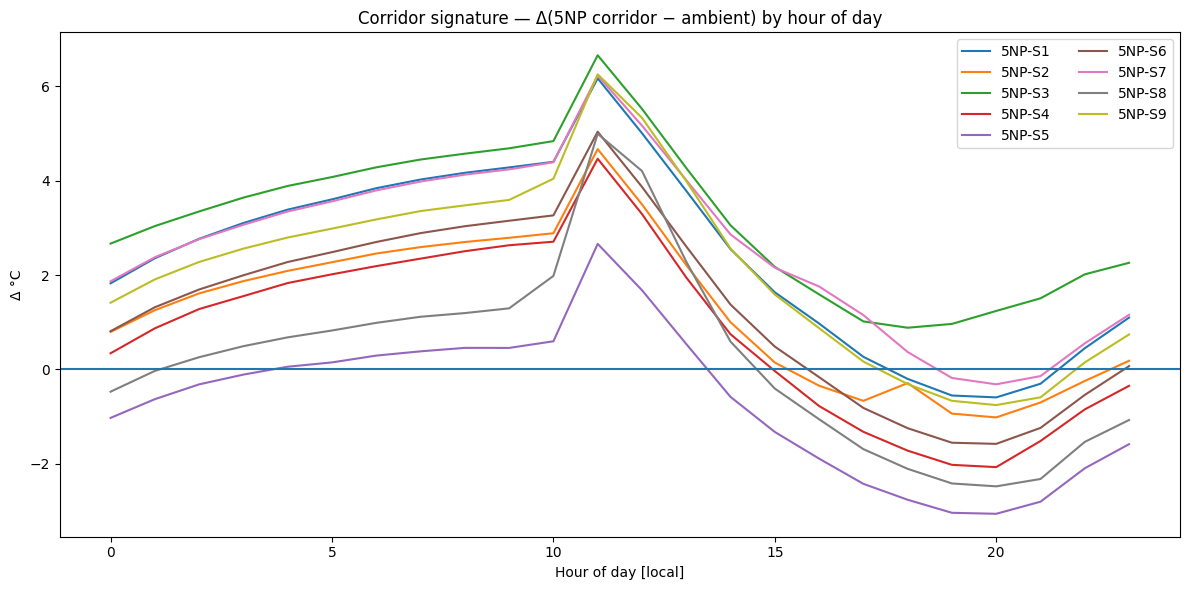

Saved: outputs/corridor_signature_5NP_vs_ambient.png


In [10]:
tp5 = summer_thermo[summer_thermo['location'].str.startswith('5NP-S', na=False)].copy()
amb_hod = summer_atrea[summer_atrea['data_key']=='temp_ambient'].copy()
amb_hod['hod'] = amb_hod['local_time'].dt.hour
amb_mean_hod = amb_hod.groupby('hod')['data_value'].mean().rename('amb_hod')

fig = plt.figure(); ax = plt.gca()
for loc, sub in tp5.groupby('location'):
    hod_mean = sub.groupby('hod')['data_value'].mean()
    aligned = pd.concat([hod_mean, amb_mean_hod], axis=1).dropna()
    dif = aligned['data_value'] - aligned['amb_hod']
    ax.plot(aligned.index, dif.values, label=loc)
ax.set_title('Corridor signature — Δ(5NP corridor − ambient) by hour of day')
ax.set_xlabel('Hour of day [local]'); ax.set_ylabel('Δ °C')
ax.axhline(0)
ax.legend(ncol=2)
plt.tight_layout(); plt.savefig(OUT_DIR / 'corridor_signature_5NP_vs_ambient.png', dpi=150); plt.show()
print('Saved:', OUT_DIR / 'corridor_signature_5NP_vs_ambient.png')


## 7) "Garage Gradient" — floor-by-floor daily means

**Why it speaks**: Reveals **heat plume from 1PP** into deeper levels.

- Compute daily mean for **1PP/2PP/3PP** and overlay per floor (summer only).

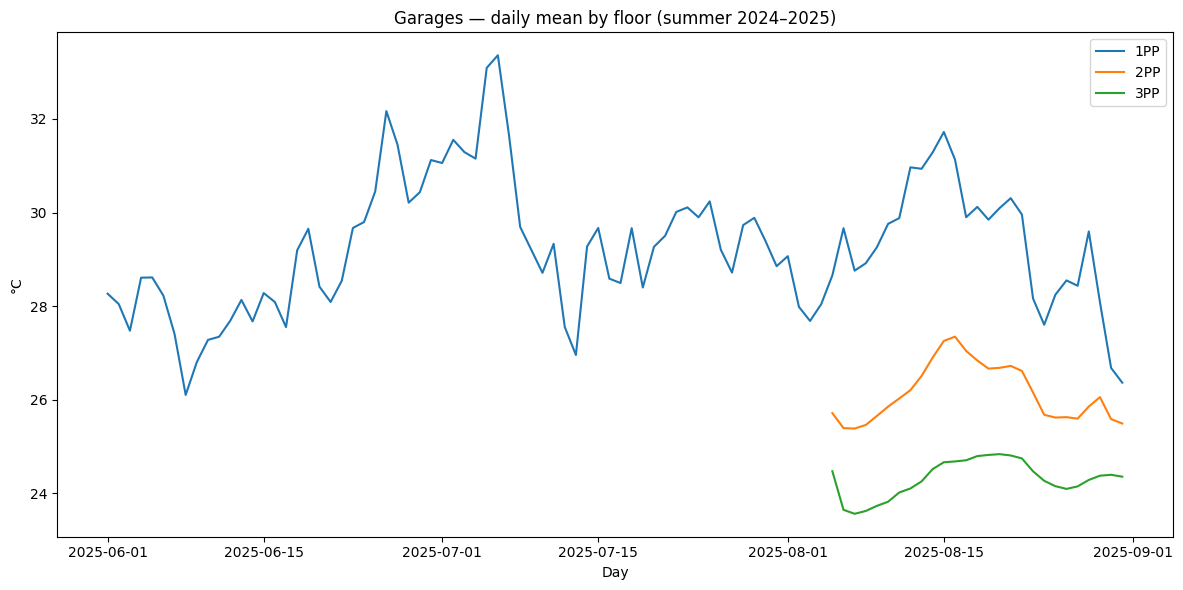

Saved: outputs/garages_daily_mean_by_floor.png


In [11]:
pp = summer_thermo[summer_thermo['location'].str.contains('PP', na=False)].copy()
def floor_of(loc):
    m = re.match(r'^(\dPP)-S\d+$', str(loc))
    return m.group(1) if m else None
pp['floor'] = pp['location'].map(floor_of)
daily = pp.groupby(['floor','local_day'])['data_value'].mean().reset_index()
fig = plt.figure(); ax = plt.gca()
for f in ['1PP','2PP','3PP']:
    sub = daily[daily['floor']==f]
    if sub.empty: continue
    ax.plot(sub['local_day'], sub['data_value'], label=f)
ax.set_title('Garages — daily mean by floor (summer 2024–2025)')
ax.set_xlabel('Day'); ax.set_ylabel('°C')
ax.legend()
plt.tight_layout(); plt.savefig(OUT_DIR / 'garages_daily_mean_by_floor.png', dpi=150); plt.show()
print('Saved:', OUT_DIR / 'garages_daily_mean_by_floor.png')


## 8) "Hottest Days Gallery" — 24h profiles on the top 5 ambient days

**Why it speaks**: Shows **day-shape** during extreme events and how indoor follows/lingers.**

- Pick **top 5 days** by **ambient daily max**.
- For each day, plot 24h profiles: `ambient`, `fresh`, `indoor` (averaged across sections).

Top 5 ambient days: ['2025-07-02', '2025-06-26', '2024-07-10', '2025-08-15', '2024-08-14']


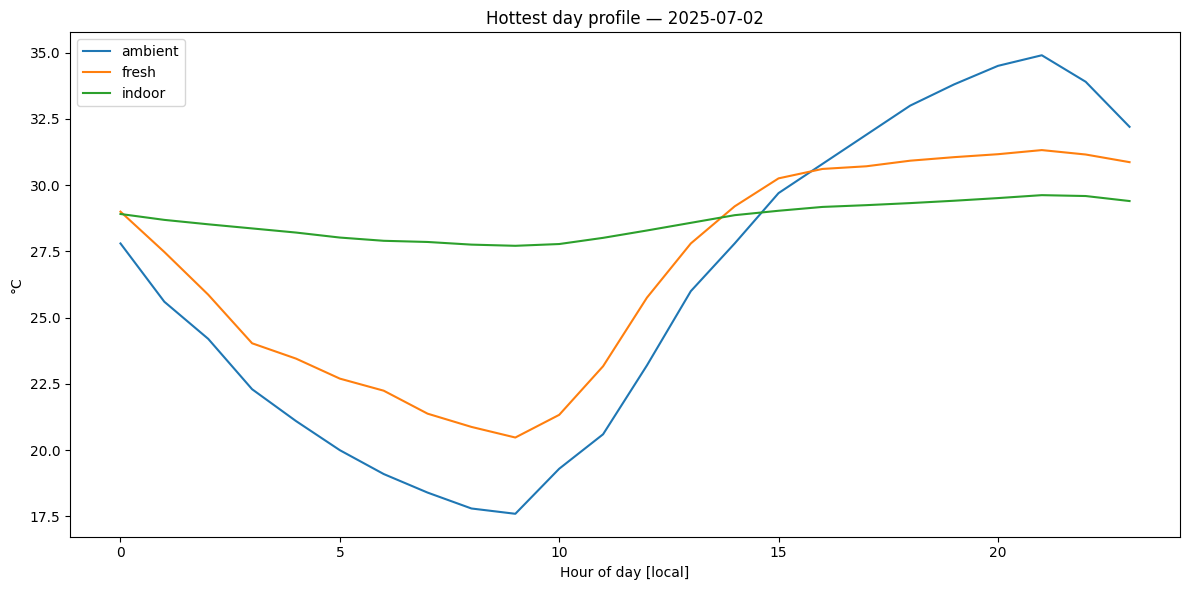

Saved: outputs/hottest_day_2025-07-02.png


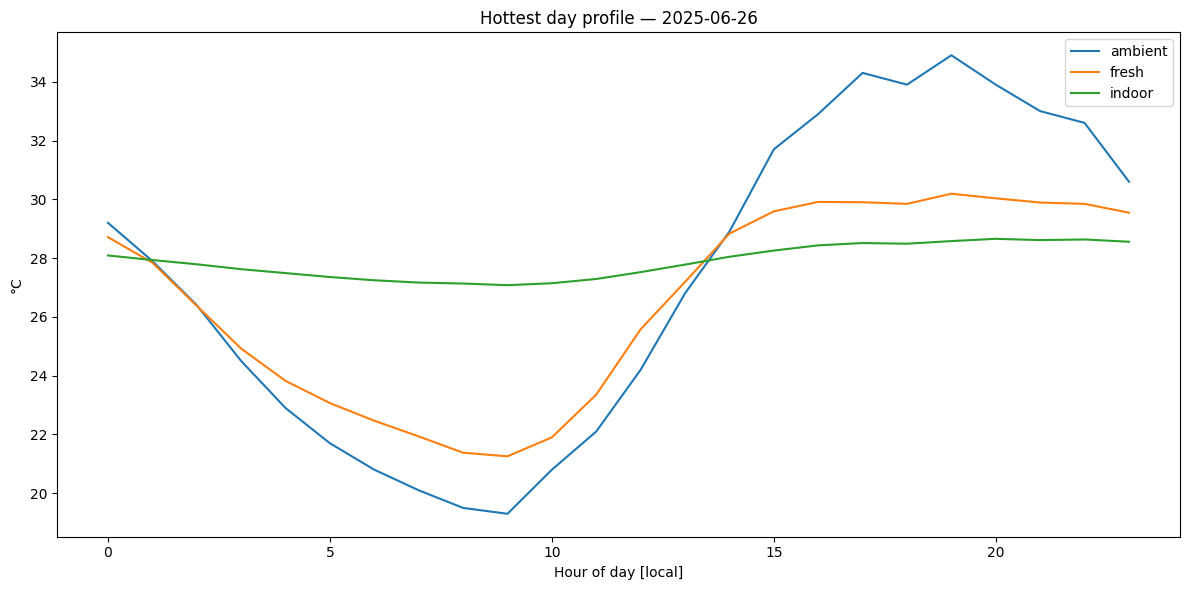

Saved: outputs/hottest_day_2025-06-26.png


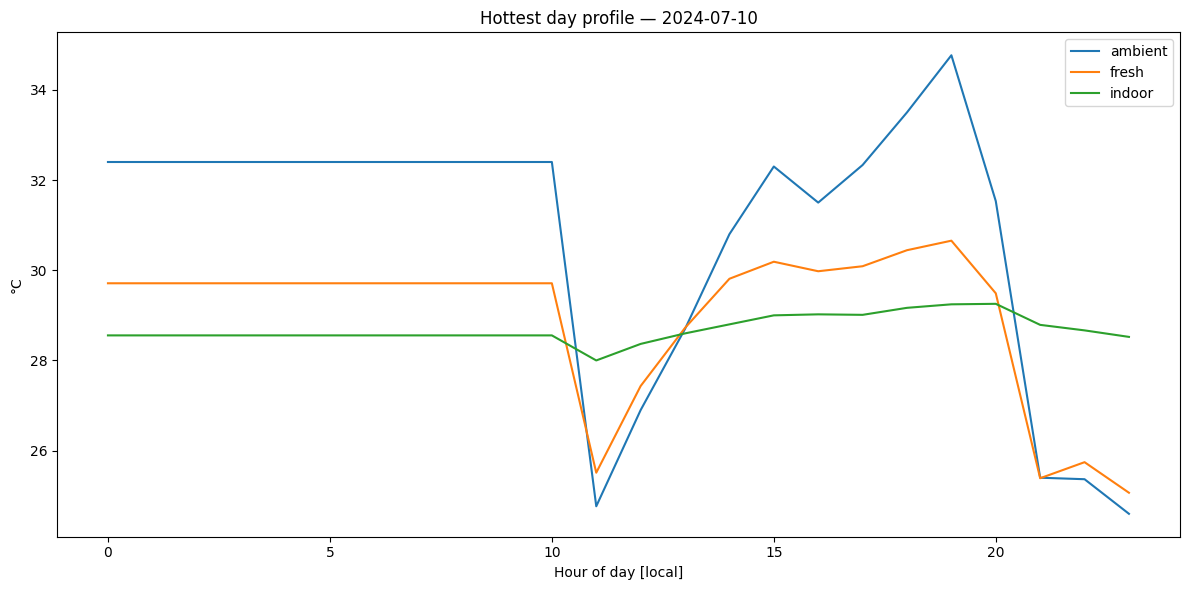

Saved: outputs/hottest_day_2024-07-10.png


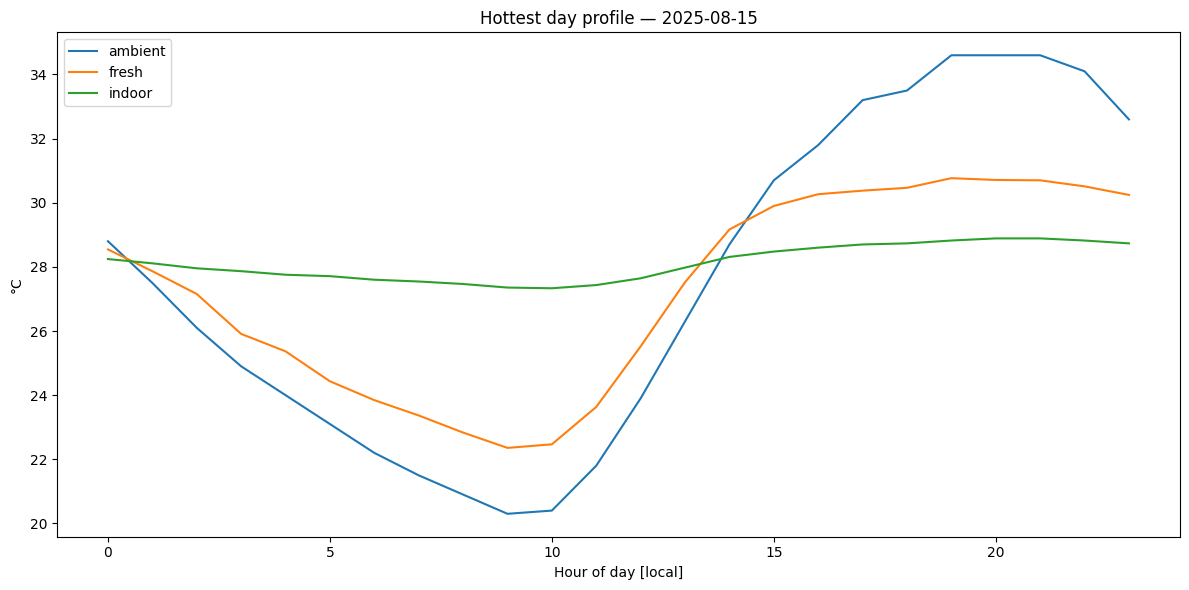

Saved: outputs/hottest_day_2025-08-15.png


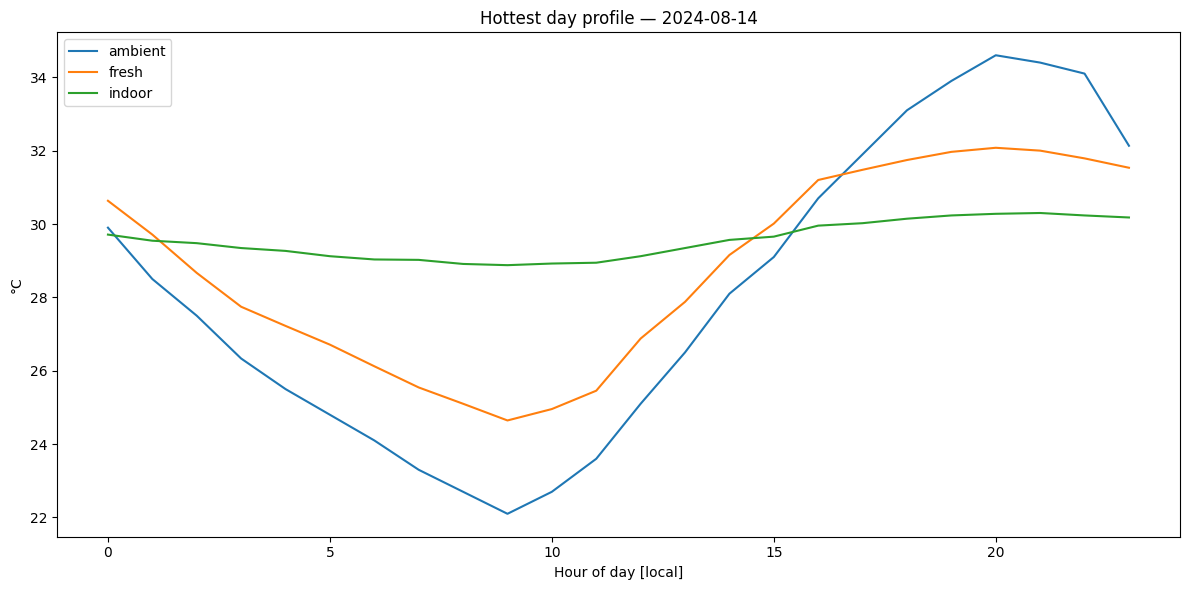

Saved: outputs/hottest_day_2024-08-14.png


In [12]:
amb_all = summer_atrea[summer_atrea['data_key']=='temp_ambient'].copy()
fresh_all = summer_atrea[summer_atrea['data_key']=='temp_fresh'].copy()
ind_all = summer_atrea[summer_atrea['data_key']=='temp_indoor'].copy()

daily_amb_max = amb_all.groupby('local_day')['data_value'].max().sort_values(ascending=False)
top_days = daily_amb_max.head(5).index.tolist()
print('Top 5 ambient days:', [str(d.date()) for d in top_days])

for day in top_days:
    start = pd.Timestamp(day.date(), tz='Europe/Prague')
    end = start + pd.Timedelta(days=1)
    a = amb_all[(amb_all['local_time']>=start) & (amb_all['local_time']<end)].copy()
    f = fresh_all[(fresh_all['local_time']>=start) & (fresh_all['local_time']<end)].copy()
    i = ind_all[(ind_all['local_time']>=start) & (ind_all['local_time']<end)].copy()
    def hod_mean(frame):
        if frame.empty:
            return None
        frame['hod'] = frame['local_time'].dt.hour
        return frame.groupby('hod')['data_value'].mean().reset_index()
    a_h, f_h, i_h = hod_mean(a), hod_mean(f), hod_mean(i)
    fig = plt.figure(); ax = plt.gca()
    if a_h is not None:
        ax.plot(a_h['hod'], a_h['data_value'], label='ambient')
    if f_h is not None:
        ax.plot(f_h['hod'], f_h['data_value'], label='fresh')
    if i_h is not None:
        ax.plot(i_h['hod'], i_h['data_value'], label='indoor')
    ax.set_title(f'Hottest day profile — {str(day.date())}')
    ax.set_xlabel('Hour of day [local]'); ax.set_ylabel('°C')
    ax.legend()
    plt.tight_layout();
    fname = OUT_DIR / f'hottest_day_{str(day.date())}.png'
    plt.savefig(fname, dpi=150); plt.show(); print('Saved:', fname)


## 9) "Section vs Ambient Offset" — summer distribution

**Why it speaks**: Some sections keep a larger **offset above ambient** than others.

- For each Atrea section, compute the **median of (temp_indoor − temp_ambient)** across summer; bar chart by section.

/tmp/ipython-input-2270572027.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  med_offsets = ind_s.groupby('location').apply(offset_series).reset_index(name='median_offset')


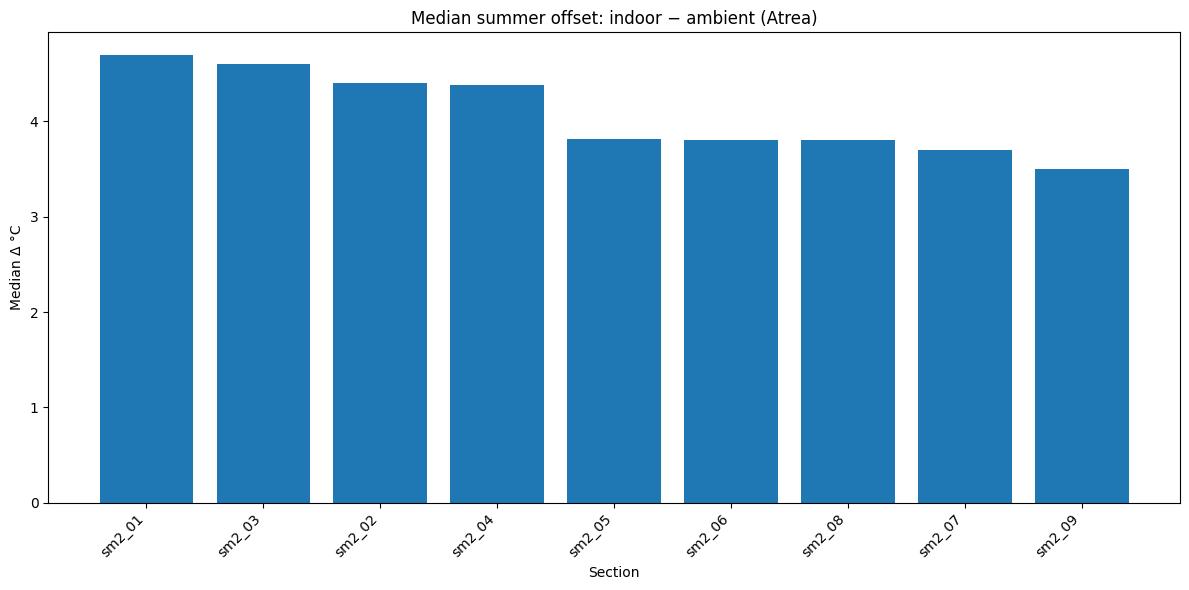

Saved: outputs/median_offset_indoor_minus_ambient_by_section.png


In [13]:
amb_s = summer_atrea[summer_atrea['data_key']=='temp_ambient'].copy()
ind_s = summer_atrea[summer_atrea['data_key']=='temp_indoor'].copy()
amb_h = amb_s.groupby('local_time')['data_value'].mean()  # ambient is shared; average across sections at timestamp
def offset_series(sub):
    aligned = sub.set_index('local_time')['data_value'].rename('ind')
    joined = pd.concat([aligned, amb_h.rename('amb')], axis=1).dropna()
    return (joined['ind'] - joined['amb']).median()

med_offsets = ind_s.groupby('location').apply(offset_series).reset_index(name='median_offset')
med_offsets = med_offsets.sort_values('median_offset', ascending=False)
fig = plt.figure(); ax = plt.gca()
ax.bar(med_offsets['location'].astype(str), med_offsets['median_offset'].values)
ax.set_title('Median summer offset: indoor − ambient (Atrea)')
ax.set_xlabel('Section'); ax.set_ylabel('Median Δ °C')
plt.xticks(rotation=45, ha='right')
plt.tight_layout(); plt.savefig(OUT_DIR / 'median_offset_indoor_minus_ambient_by_section.png', dpi=150); plt.show()
print('Saved:', OUT_DIR / 'median_offset_indoor_minus_ambient_by_section.png')


### Wrap-up
These visuals aim to **show**, not tell:
- **Fingerprints** reveal diurnal patterns and persistent warm nights.
- **Cumulative burden** and **rank race** expose chronic laggards.
- **Night gap** and **lag scatter** quantify inertia.
- **Corridor signatures** and **garage gradients** illustrate secondary heat stores.
- **Hottest-day galleries** make extreme days tangible.
